In [52]:
# run_with_new_generator.py  (edited version)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# Typography / plot style (legends are mechanism names only)
mpl.rc('font', family='serif', serif=['Times New Roman'])
mpl.rcParams.update({
    'text.usetex': False,
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
})
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 30

# --- NEW: your data utilities (replaces the old data_utils import) ---
from data_utils_new import (
    gen_correlated_pairs,   # <— unified generator (single pair or multi-pair)
    get_true_frequencies,
)

# --- baselines ---
from metrics import compute_mse
from spl import random_split_perturb, random_split_estimate
from rs_fd import rs_fd_perturb, rs_fd_estimate
from rs_rfd import rs_rfd_perturb, rs_rfd_estimate

from corr_rr_fixed_new import (
    corr_rr_phase1_spl,
    corr_rr_phase2_perturb,
    corr_rr_estimate,
    combine_phase_estimates,
    optimal_p_y,
    build_p_y_table,
)

# ---------------- helpers ----------------

def _normalize_dist(d):
    vals = np.array([max(0.0, float(v)) for v in d.values()], dtype=float)
    s = vals.sum()
    if s <= 0:
        k = len(vals)
        vals = np.full(k, 1.0 / k)
    else:
        vals = vals / s
    return {k: vals[i] for i, k in enumerate(d.keys())}

def _build_p_y_table_minimal(est_I, epsilon, n2, domain, cols):
    """
    Build p_y[(a->b)] for all ordered pairs using corr_rr.optimal_p_y().
    Signature kept identical to what you previously used.
    """
    return {
        (a, b): float(optimal_p_y(est_I[a], est_I[b], epsilon, n2, domain))
        for a in cols for b in cols if a != b
    }

# ---------------- one-shot runner ----------------

def run_all_once(
    df,
    epsilon,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,   # Phase I fraction for RS+RFD two-phase prior learning
):
    """
    Compute per-mechanism MSEs on one dataset for a given ε.
    Returns dict with keys: "SPL", "RS+FD", "RS+RFD", optionally "Corr-RR".
    """
    cols = list(df.columns)
    domains = {c: sorted(df[c].unique().tolist()) for c in cols}
    true_freqs = get_true_frequencies(df, cols)

    out = {}

    # --- SPL ---
    rpt = random_split_perturb(df, epsilon)
    est = random_split_estimate(rpt, df, epsilon)
    out["SPL"] = np.mean([compute_mse(true_freqs[c], est[c]) for c in cols])

    # --- RS+FD ---
    pert_rsfd = rs_fd_perturb(df, domains, epsilon)
    est_rsfd = rs_fd_estimate(pert_rsfd, domains, epsilon)
    out["RS+FD"] = np.mean([compute_mse(true_freqs[c], est_rsfd[c]) for c in cols])

    # --- RS+RFD (Two-phase variant: Phase I used to learn priors; final = COMBINED) ---
    est_I_rsrfd, df_B_rsrfd, doms_rsrfd = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_rsrfd)
    n1_rsrfd = len(df) - len(df_B_rsrfd)
    n2_rsrfd = len(df_B_rsrfd)

    priors_2p = {col: _normalize_dist(est_I_rsrfd[col]) for col in est_I_rsrfd}
    pert_rsrfd_2p = rs_rfd_perturb(df_B_rsrfd, doms_rsrfd, priors_2p, epsilon)
    est_II_rsrfd = rs_rfd_estimate(pert_rsrfd_2p, doms_rsrfd, priors_2p, epsilon)

    # FINAL: count-weighted combine Phase I (SPL) and Phase II (RS+RFD)
    combined_rsrfd = combine_phase_estimates(est_I_rsrfd, est_II_rsrfd, n1_rsrfd, n2_rsrfd)
    out["RS+RFD"] = np.mean([compute_mse(true_freqs[c], combined_rsrfd[c]) for c in cols])

    # --- Corr-RR (optional) ---
    if use_corr_rr:
        est_I, df_B, doms_stable = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_corr)
        n1 = len(df) - len(df_B)
        n2 = len(df_B)
        common_domain = doms_stable[cols[0]]  # assumes common domain

        # Build p_y table
        p_y_table = _build_p_y_table_minimal(est_I, epsilon, n2, common_domain, cols)
        # (Alternatively: p_y_table = build_p_y_table(est_I, n2, doms_stable))

        # Phase II
        pert_corr = corr_rr_phase2_perturb(df_B, epsilon, est_I, doms_stable, p_y_table)

        # Estimation and combine
        est_II = corr_rr_estimate(pert_corr, doms_stable, epsilon)
        combined_est = combine_phase_estimates(est_I, est_II, n1, n2)
        out["Corr-RR"] = np.mean([compute_mse(true_freqs[c], combined_est[c]) for c in cols])

    return out

# ---------------- sweep & plot ----------------

def sweep_all(
    n=10000,
    epsilons=(0.2, 0.4, 0.6, 0.8, 1.0),
    R=50,
    corr=0.9,                 # global rho for all pairs
    plot_dir=None,
    csv_dir=None,
    seed=None,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
    domain=None,
    odd_marginals=None,       # dict for X1 only OR list [p1,p3,p5,...]
    q_marginal=None,          # None => uniform for the "non-copy" branch
):
    """
    Run R trials for each ε, average MSEs, and plot.
    RS+RFD is the TWO-PHASE variant. Corr-RR optional.

    Data is generated with gen_correlated_pairs(...):
      - If odd_marginals is a dict/list for ONE marginal => produce (X1, X2) only
      - If odd_marginals is a list of marginals         => produce (X1,X2),(X3,X4),...
    """
    # Defaults
    if domain is None:
        domain = [0, 1]  # keep your binary case unless you change it

    if odd_marginals is None:
        # default: balanced X1 marginal (single pair)
        odd_marginals = {domain[0]: 0.5, domain[1]: 0.5}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(epsilons)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    attr_count = None
    domain_size = len(domain)

    for run in range(R):
        # ---- NEW: generate with your new sampler ----
        df = gen_correlated_pairs(
            n=n,
            domain=domain,
            rho=corr,
            odd_marginals=odd_marginals,   # single marginal or list of marginals
            q_marginal=q_marginal,         # None -> uniform
            seed=None if seed is None else (seed + run + int(1000 * corr)),
        )

        if attr_count is None:
            attr_count = df.shape[1]

        for j, eps in enumerate(epsilons):
            res = run_all_once(
                df,
                eps,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac_phase1_corr,
                frac_phase1_rsrfd=frac_phase1_rsrfd,
            )
            for k in keys:
                means[k][j] += res[k]

    for k in keys:
        means[k] /= R

    # Plot
    plt.figure(figsize=(10, 8))
    plt.plot(epsilons, means["SPL"],         '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(epsilons, means["RS+FD"],       '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(epsilons, means["RS+RFD"],      '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(epsilons, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')

    plt.xlabel(r'$ϵ$', fontsize=50)
    plt.ylabel('MSE',  fontsize=40)
    plt.xticks(epsilons, labels=[str(e) for e in epsilons])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.legend(fontsize=35, loc='upper right', frameon=True, edgecolor='black')
    plt.tight_layout()

    # Output filenames
    def _fmt(x): return f"{x:g}"
    base = f"mseVSepsilon_{attr_count}attribute_{domain_size}domain_n_{n}_frac_{_fmt(frac_phase1_rsrfd)}_corr_{_fmt(corr)}"

    # Save PDF
    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        pdf_path = os.path.join(plot_dir, base + ".pdf")
        plt.savefig(pdf_path, format="pdf")

    plt.show()

    # Save CSV
    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        df_out = pd.DataFrame({"epsilon": list(epsilons)})
        for k in keys:
            df_out[k] = means[k]
        csv_path = os.path.join(csv_dir, base + ".csv")
        df_out.to_csv(csv_path, index=False)

    return means

# ---------------- main ----------------



In [ ]:
# run_with_new_generator.py  (edited version)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# Typography / plot style (legends are mechanism names only)
mpl.rc('font', family='serif', serif=['Times New Roman'])
mpl.rcParams.update({
    'text.usetex': False,
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
})
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 30

# --- NEW: your data utilities (replaces the old data_utils import) ---
from data_utils_new import (
    gen_correlated_pairs,   # <— unified generator (single pair or multi-pair)
    get_true_frequencies,
)

# --- baselines ---
from metrics import compute_mse
from spl import random_split_perturb, random_split_estimate
from rs_fd import rs_fd_perturb, rs_fd_estimate
from rs_rfd import rs_rfd_perturb, rs_rfd_estimate

from corr_rr_fixed_new import (
    corr_rr_phase1_spl,
    corr_rr_phase2_perturb,
    corr_rr_estimate,
    combine_phase_estimates,
    optimal_p_y,
    build_p_y_table,
)

# ---------------- helpers ----------------

def _normalize_dist(d):
    vals = np.array([max(0.0, float(v)) for v in d.values()], dtype=float)
    s = vals.sum()
    if s <= 0:
        k = len(vals)
        vals = np.full(k, 1.0 / k)
    else:
        vals = vals / s
    return {k: vals[i] for i, k in enumerate(d.keys())}

def _build_p_y_table_minimal(est_I, epsilon, n2, domain, cols):
    """
    Build p_y[(a->b)] for all ordered pairs using corr_rr.optimal_p_y().
    Signature kept identical to what you previously used.
    """
    return {
        (a, b): float(optimal_p_y(est_I[a], est_I[b], epsilon, n2, domain))
        for a in cols for b in cols if a != b
    }

# ---------------- one-shot runner ----------------

def run_all_once(
    df,
    epsilon,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,   # Phase I fraction for RS+RFD two-phase prior learning
):
    """
    Compute per-mechanism MSEs on one dataset for a given ε.
    Returns dict with keys: "SPL", "RS+FD", "RS+RFD", optionally "Corr-RR".
    """
    cols = list(df.columns)
    domains = {c: sorted(df[c].unique().tolist()) for c in cols}
    true_freqs = get_true_frequencies(df, cols)

    out = {}

    # --- SPL ---
    rpt = random_split_perturb(df, epsilon)
    est = random_split_estimate(rpt, df, epsilon)
    out["SPL"] = np.mean([compute_mse(true_freqs[c], est[c]) for c in cols])

    # --- RS+FD ---
    pert_rsfd = rs_fd_perturb(df, domains, epsilon)
    est_rsfd = rs_fd_estimate(pert_rsfd, domains, epsilon)
    out["RS+FD"] = np.mean([compute_mse(true_freqs[c], est_rsfd[c]) for c in cols])

    # --- RS+RFD (Two-phase variant: Phase I used to learn priors; final = COMBINED) ---
    est_I_rsrfd, df_B_rsrfd, doms_rsrfd = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_rsrfd)
    n1_rsrfd = len(df) - len(df_B_rsrfd)
    n2_rsrfd = len(df_B_rsrfd)

    priors_2p = {col: _normalize_dist(est_I_rsrfd[col]) for col in est_I_rsrfd}
    pert_rsrfd_2p = rs_rfd_perturb(df_B_rsrfd, doms_rsrfd, priors_2p, epsilon)
    est_II_rsrfd = rs_rfd_estimate(pert_rsrfd_2p, doms_rsrfd, priors_2p, epsilon)

    # FINAL: count-weighted combine Phase I (SPL) and Phase II (RS+RFD)
    combined_rsrfd = combine_phase_estimates(est_I_rsrfd, est_II_rsrfd, n1_rsrfd, n2_rsrfd)
    out["RS+RFD"] = np.mean([compute_mse(true_freqs[c], combined_rsrfd[c]) for c in cols])

    # --- Corr-RR (optional) ---
    if use_corr_rr:
        est_I, df_B, doms_stable = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_corr)
        n1 = len(df) - len(df_B)
        n2 = len(df_B)
        common_domain = doms_stable[cols[0]]  # assumes common domain

        # Build p_y table
        p_y_table = _build_p_y_table_minimal(est_I, epsilon, n2, common_domain, cols)
        # (Alternatively: p_y_table = build_p_y_table(est_I, n2, doms_stable))

        # Phase II
        pert_corr = corr_rr_phase2_perturb(df_B, epsilon, est_I, doms_stable, p_y_table)

        # Estimation and combine
        est_II = corr_rr_estimate(pert_corr, doms_stable, epsilon)
        combined_est = combine_phase_estimates(est_I, est_II, n1, n2)
        out["Corr-RR"] = np.mean([compute_mse(true_freqs[c], combined_est[c]) for c in cols])

    return out

# ---------------- sweep & plot ----------------

def sweep_all(
    n=10000,
    epsilons=(0.2, 0.4, 0.6, 0.8, 1.0),
    R=50,
    corr=0.99,                 # global rho for all pairs
    plot_dir=None,
    csv_dir=None,
    seed=None,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
    domain=None,
    odd_marginals=None,       # dict for X1 only OR list [p1,p3,p5,...]
    q_marginal=None,          # None => uniform for the "non-copy" branch
):
    """
    Run R trials for each ε, average MSEs, and plot.
    RS+RFD is the TWO-PHASE variant. Corr-RR optional.

    Data is generated with gen_correlated_pairs(...):
      - If odd_marginals is a dict/list for ONE marginal => produce (X1, X2) only
      - If odd_marginals is a list of marginals         => produce (X1,X2),(X3,X4),...
    """
    # Defaults
    if domain is None:
        domain = [0, 1]  # keep your binary case unless you change it

    if odd_marginals is None:
        # default: balanced X1 marginal (single pair)
        odd_marginals = {domain[0]: 0.5, domain[1]: 0.5}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(epsilons)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    attr_count = None
    domain_size = len(domain)

    for run in range(R):
        # ---- NEW: generate with your new sampler ----
        df = gen_correlated_pairs(
            n=n,
            domain=domain,
            rho=corr,
            odd_marginals=odd_marginals,   # single marginal or list of marginals
            q_marginal=q_marginal,         # None -> uniform
            seed=None if seed is None else (seed + run + int(1000 * corr)),
        )

        if attr_count is None:
            attr_count = df.shape[1]

        for j, eps in enumerate(epsilons):
            res = run_all_once(
                df,
                eps,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac_phase1_corr,
                frac_phase1_rsrfd=frac_phase1_rsrfd,
            )
            for k in keys:
                means[k][j] += res[k]

    for k in keys:
        means[k] /= R

    # Plot
    plt.figure(figsize=(10, 8))
    plt.plot(epsilons, means["SPL"],         '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(epsilons, means["RS+FD"],       '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(epsilons, means["RS+RFD"],      '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(epsilons, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')

    plt.xlabel(r'$ϵ$', fontsize=50)
    plt.ylabel('MSE',  fontsize=40)
    plt.xticks(epsilons, labels=[str(e) for e in epsilons])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.legend(fontsize=35, loc='upper right', frameon=True, edgecolor='black')
    plt.tight_layout()

    # Output filenames
    def _fmt(x): return f"{x:g}"
    base = f"mseVSepsilon_{attr_count}attribute_{domain_size}domain_n_{n}_frac_{_fmt(frac_phase1_rsrfd)}_corr_{_fmt(corr)}"

    # Save PDF
    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        pdf_path = os.path.join(plot_dir, base + ".pdf")
        plt.savefig(pdf_path, format="pdf")

    plt.show()

    # Save CSV
    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        df_out = pd.DataFrame({"epsilon": list(epsilons)})
        for k in keys:
            df_out[k] = means[k]
        csv_path = os.path.join(csv_dir, base + ".csv")
        df_out.to_csv(csv_path, index=False)

    return means

# ---------------- main ----------------

if __name__ == "__main__":
    eps = [0.2, 0.4, 0.6, 0.8, 1.0]

    # === Choose your data spec ===
    domain = [0, 1]  # same domain for every attribute

    # (A) Single pair: only X1,X2 (this mirrors your older experiments)
    x1_marginal = {0: 0.55, 1: 0.45}   # edit as you like
    odd_marginals = x1_marginal

    # (B) Multi-pair example (uncomment to use):
    # x1_marginal = {0: 0.55, 1: 0.45}  # for X1
    # x3_marginal = {0: 0.20, 1: 0.80}  # for X3
    # x5_marginal = {0: 0.35, 1: 0.65}  # for X5
    # odd_marginals = [x1_marginal, x3_marginal, x5_marginal]  # -> X1..X6

    means = sweep_all(
        n=5000,
        epsilons=eps,
        R=1,
        corr=0.93,                 # global rho applied to every pair
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        #plot_dir=r"C:\\Users\\ss6365\\Desktop\\pet_final",
        #csv_dir=r"C:\\Users\\ss6365\\Desktop\\pet_final\\data",
        domain=domain,
        odd_marginals=odd_marginals,  # single OR list
        q_marginal=None,              # None => uniform drift for even attributes
    )


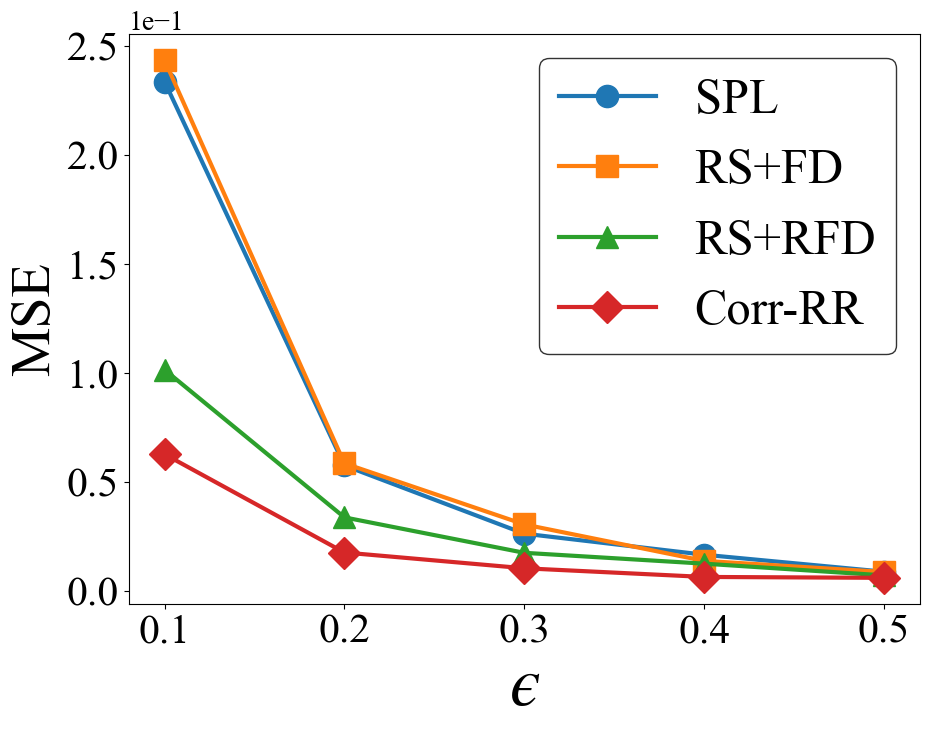

In [49]:
if __name__ == "__main__":
    eps = [0.1, 0.2, 0.3, 0.4, 0.5]

    # === Data spec ===
    domain = [0, 1, 2, 3]  # same domain for all attributes

    # Marginals for odd attributes
    x1_marginal = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1}   # for X1
    x3_marginal = {0: 0.1, 1: 0.2, 2: 0.3, 3: 0.4}   # for X3 (example)

    # Tell the generator: two odd marginals => X1..X4
    odd_marginals = [x1_marginal, x3_marginal]

    means = sweep_all(
        n=20000,
        epsilons=eps,
        R=10,
        corr=0.1,                 # global rho applied to both pairs
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        domain=domain,
        odd_marginals=odd_marginals,  # now a list -> X1..X4
        q_marginal=None,              # None => uniform drift for even attrs
    )


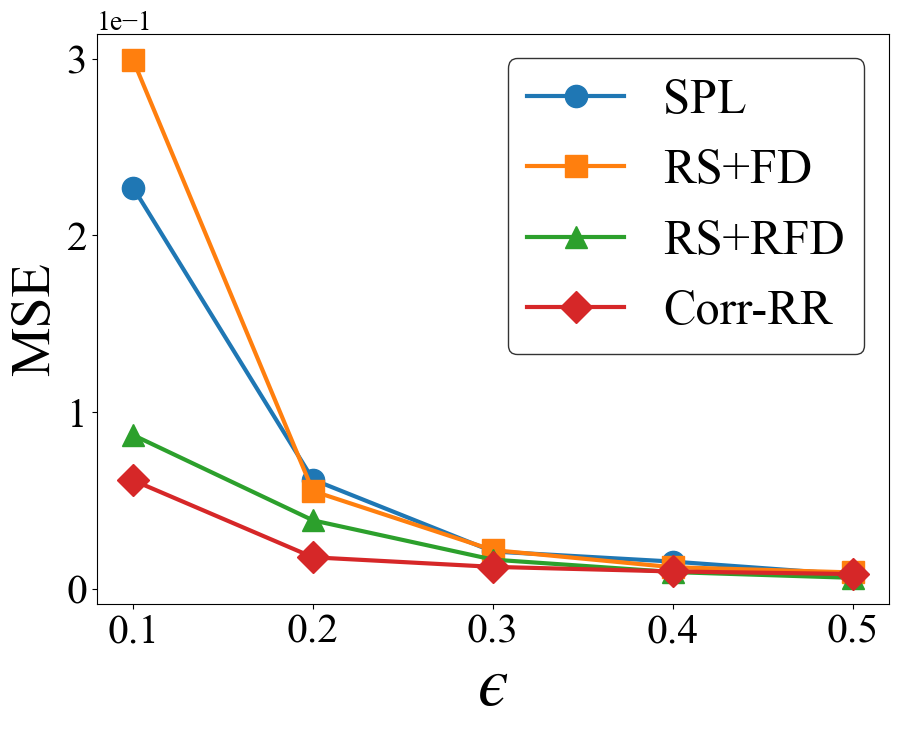

In [51]:
if __name__ == "__main__":
    eps = [0.1, 0.2, 0.3, 0.4, 0.5]

    # === Data spec ===
    domain = [0, 1, 2, 3]  # same domain for all attributes

    # Marginals for odd attributes
    x1_marginal = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1}   # for X1
    x3_marginal = {0: 0.1, 1: 0.2, 2: 0.3, 3: 0.4}   # for X3 (example)

    # Tell the generator: two odd marginals => X1..X4
    odd_marginals = [x1_marginal, x3_marginal]

    means = sweep_all(
        n=20000,
        epsilons=eps,
        R=10,
        corr=0.9,                 # global rho applied to both pairs
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        domain=domain,
        odd_marginals=odd_marginals,  # now a list -> X1..X4
        q_marginal=None,              # None => uniform drift for even attrs
    )
